# In this assignment we learn how to derive a neural network emulator based on the cosmopower emulator (Mancini et al. 2021). Based on this emulator we perform a PCA data compression.

### For this assignment you need the install cosmopower yourself https://github.com/alessiospuriomancini/cosmopower or you just use the cosmopower_NN.py module that is provided. However in the latter case you need to install tensorflow: https://www.tensorflow.org/install

In [1]:
import matplotlib.pyplot as plt
import random
import numpy as np
from numpy.linalg import inv
from cosmopower_NN import cosmopower_NN
import tensorflow as tf

## Preparation: load in the all the 10000 model vectors and corresponding parameters that we use to built the emulator.

In [2]:
models = np.load('data_4_assignment2/models.npy')
parameters = np.load('data_4_assignment2/parameters.npz')
parameters.keys(),models.shape

(KeysView(NpzFile 'data_4_assignment2/parameters.npz' with keys: omega_m, omega_b, As, w),
 (10000, 900))

#### Divide the models and parameters in a training and test set.

In [3]:
train_sample = np.arange(0, 8000) # 80% of elements used for training
test_sample = np.arange(8000, 10000) # 20% of elements used for testing

train_params = {}
for name in parameters.keys():
    train_params[name]=list(np.array(parameters[name])[train_sample])
test_params = {}
for name in parameters.keys():
    test_params[name]=list(np.array(parameters[name])[test_sample])

train_features = models[train_sample]
test_features = models[test_sample]

#### Train the emulator. Reasonable hyper parameters are set already, but test out other settings and comment on what you observe regarding accuracy and speed.

In [ ]:
# We modify the training features ahead of time by dividing by the standard
# deviation among all vectors (such that the resulting data vector is of the
# same order of magnitude, to prevent underfitting the very small values)
features_modified = train_features / np.std(train_features, axis=0)

# Using three layers with 4, 5, 6 nodes was NOT enough; instead we increase by
# a large amount and add an additional layer – this increases the runtime
# somewhat but also boosts accuracy significantly
cp_nn = cosmopower_NN(parameters=list(parameters.keys()),
                      modes=np.linspace(-1,1,train_features.shape[1]),
                      n_hidden = [512, 512, 512, 512],
                      verbose=True, # Prints out progress as we go
                     )

device = 'cpu'
with tf.device(device):
    # Trains the neural network
    cp_nn.train(training_parameters=train_params,
                training_features=features_modified,
                # Name of emulator and where to store it
                filename_saved_model='data_4_assignment2/emulator_test',
                # Percentage of training sample to use for validation
                validation_split=0.1,
                # Different learning rates
                learning_rates=[1e-2, 1e-3, 1e-4, 1e-5],
                # Number of models to use for adjusting parameters
                batch_sizes=[500, 500, 500, 500],
                gradient_accumulation_steps=[1, 1, 1, 1],
                # Number epochs to wait before decreasing learning rate if loss
                # does not improve anymore
                patience_values = [100, 100, 100, 100],
                # Max number epochs to wait before decreasing learning rate
                max_epochs = [1000, 1000, 1000, 1000],
                )

# The range of learning rates used are small enough to avoid getting stuck, but
# also large enough that they don't stop becoming effective by decreasing further

# Likewise the batch sizes were chosen to strike a balance between runtime and
# accuracy (increasing decreases runtime but also decreases accuracy)

# The max epochs were also made sufficiently big such that we don't run out of
# iterations before proceeding to the next learning rate


Initialized cosmopower_NN model, 
mapping 4 input parameters to 900 output modes, 
using 4 hidden layers, 
with [512, 512, 512, 512] nodes, respectively. 

Starting cosmopower_NN training, 
using 10 per cent of training samples for validation. 
Performing 4 learning steps, with 
[0.01, 0.001, 0.0001, 1e-05] learning rates 
[500, 500, 500, 500] batch sizes 
[1, 1, 1, 1] gradient accumulation steps 
[100, 100, 100, 100] patience values 
[1000, 1000, 1000, 1000] max epochs 

learning rate = 0.01, batch size = 500


 47%|████▋     | 468/1000 [26:58<30:39,  3.46s/it, loss=0.0312]


Validation loss = 0.0118826935
Model saved.
Reached max number of epochs. Validation loss = 0.0118826935
Model saved.
learning rate = 0.001, batch size = 500


 29%|██▊       | 286/1000 [14:44<36:49,  3.09s/it, loss=0.00268]


Validation loss = 0.001176322
Model saved.
Reached max number of epochs. Validation loss = 0.001176322
Model saved.
learning rate = 0.0001, batch size = 500


 62%|██████▏   | 623/1000 [29:45<18:00,  2.87s/it, loss=0.000507]


Validation loss = 0.00049431826
Model saved.
Reached max number of epochs. Validation loss = 0.00049431826
Model saved.
learning rate = 1e-05, batch size = 500


 10%|█         | 102/1000 [05:03<44:29,  2.97s/it, loss=0.000443]

Validation loss = 0.0004322399
Model saved.
Reached max number of epochs. Validation loss = 0.0004322399
Model saved.


#### Check the accuracy of the emulator, by computing how many predictions are inside 68%, 95%, 99%.


Initialized cosmopower_NN model, 
mapping 4 input parameters to 900 output modes, 
using 4 hidden layers, 
with [512, 512, 512, 512] nodes, respectively. 



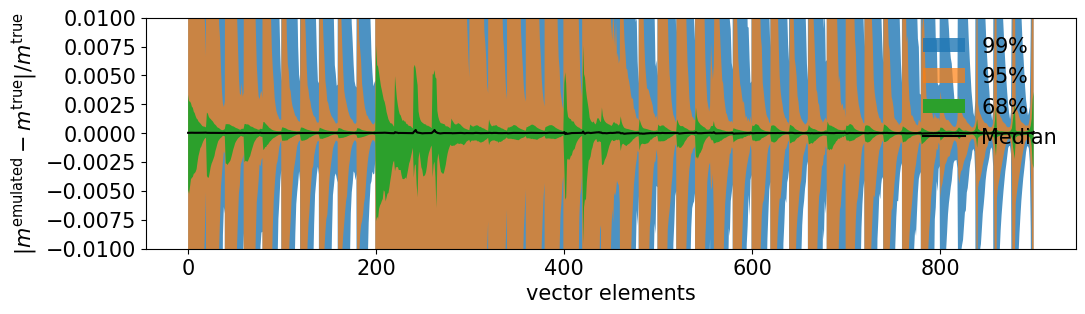

In [4]:
# Reads in the stored emulator results (to avoid having to re-run)
cp_nn = cosmopower_NN(parameters=list(parameters.keys()),
                      modes=np.linspace(-1,1,train_features.shape[1]),
                      n_hidden = [512, 512, 512, 512],
                      verbose=True, # Prints out progress as we go
                     )
cp_nn.restore(filename='data_4_assignment2/emulator_test')

# Retrieves the predicted features based on test parameters (and converts back
# to original data using the inverse transformation applied before)
emulated_features = cp_nn.predictions_np(test_params)
emulated_features *= np.std(train_features, axis=0)

# Measures relative difference between test and emulated models
diff = emulated_features / test_features - 1

# Obtains the median and percentile errors associated with predictions vs
# observed for purposes of plotting
median_diff = np.median(diff, axis=0)
percentiles1 = np.percentile(diff, [16, 84], axis=0)
percentiles2 = np.percentile(diff, [2.5, 97.5], axis=0)
percentiles3 = np.percentile(diff, [0.5, 99.5], axis=0)
bins=range(diff.shape[1])

plt.figure(figsize=(12, 3),dpi=100)
plt.fill_between(x=bins, y1=percentiles3[0], y2=percentiles3[1],
                 label='$99\%$', alpha=0.8)
plt.fill_between(x=bins, y1=percentiles2[0], y2=percentiles2[1],
                 label='$95\%$', alpha = 0.7)
plt.fill_between(x=bins, y1=percentiles1[0], y2=percentiles1[1],
                 label='$68\%$', alpha = 1)
plt.plot(bins,median_diff,'-',color='black', label='Median')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(frameon=False, fontsize=15, loc='upper right')
plt.ylabel(r'$|m^{\mathrm{emulated}} - m^{\mathrm{true}}|/  m^{\mathrm{true}}$',
           fontsize=15)
plt.xlabel(r'vector elements', fontsize=15)
plt.ylim(-0.01, 0.01)
plt.show()

##### Next we want perform a Fisher Analysis using the emulator. We want you to compute the covariance of the parameters $\Theta = \{\Omega_\mathrm{m},w\}$, which can be estimated by $C(\Theta) = F^{-1}$, where $$F_{ij}= \left(\frac{\partial m(\Theta)}{\partial \Theta_i}\right)^{T} C^{-1} \left(\frac{\partial m(\Theta)}{\partial \Theta_i}\right)$$
##### For the partial derivatives we use the five point stencil beam given by $$\frac{\partial m(\Theta)}{\partial \Theta_i}\approx \frac{-m(\Theta_i + 2\
\Delta \Theta_i) + 8 \ m(\Theta_i +  \Delta \Theta_i) - 8 \ m(\Theta_i - \Delta \Theta_i) + m(\Theta_i - 2\ \Delta \Theta_i)}{12 \ \Delta \Theta_i }$$

In [5]:
# We choose a reasonable step size for Omega_m and w
om_shift = 0.01
w_shift =  0.01

# We compute the numerical derivatives by varying the parameters individually
# one at a time (centred about their mean values)
mean_om = np.mean(test_params['omega_m'])
mean_w = np.mean(test_params['w'])
mean_As = np.mean(test_params['As'])
mean_ob = np.mean(test_params['omega_b'])
parameters_om = {'omega_m':[mean_om - 2*om_shift, mean_om - om_shift,
                            mean_om + om_shift, mean_om + 2*om_shift],
                 'w':[mean_w, mean_w, mean_w, mean_w],
                 'As':[mean_As, mean_As, mean_As, mean_As],
                 'omega_b':[mean_ob, mean_ob, mean_ob, mean_ob]}
parameters_w = {'omega_m':[mean_om, mean_om, mean_om, mean_om],
                 'w':[mean_w - 2*w_shift, mean_w - w_shift,
                      mean_w + w_shift, mean_w + 2*w_shift],
                 'As':[mean_As, mean_As, mean_As, mean_As],
                 'omega_b':[mean_ob, mean_ob, mean_ob, mean_ob]}

# Like before, we must apply inverse transformation to the resulting features
features_om = cp_nn.predictions_np(parameters_om)
features_om *= np.std(train_features, axis=0)
features_w = cp_nn.predictions_np(parameters_w)
features_w *= np.std(train_features, axis=0)

# Applies five point stencil beam to compute the derivatives
derivative_Om = np.array([(-features_om[3] + 8*features_om[2] -
                          8*features_om[1] + features_om[0])/(12*om_shift)]).T
derivative_w = np.array([(-features_w[3] + 8*features_w[2] -
                         8*features_w[1] + features_w[0])/(12*w_shift)]).T

#### So lets compute the Fisher matrix the corresponding covariance matrix of the parameters:

In [6]:
# We use the analytic covariance matrix from assigment 1 for this
cov=np.load('data_4_assignment1/covariance.npy')
inv_cov = inv(cov)

# Computes the components of the Fisher matrix and inverts to get parameter
# covariance matrix
FoM_11 = np.matmul(np.matmul(derivative_Om.T, inv_cov), derivative_Om)[0][0]
FoM_22 = np.matmul(np.matmul(derivative_w.T, inv_cov), derivative_w)[0][0]
FoM_12 = np.matmul(np.matmul(derivative_Om.T, inv_cov), derivative_w)[0][0]
FoM_best = np.array([[FoM_11,FoM_12],[FoM_12,FoM_22]])
Cov_parameter = np.linalg.inv(FoM_best)
Cov_parameter,np.sqrt(np.diag(Cov_parameter))

(array([[6.14882845e-07, 1.17103098e-05],
        [1.17103098e-05, 3.18539044e-04]]),
 array([0.00078414, 0.01784766]))

#### First you need to generate the transformation from our model/data vectors to the PCA elements based on the 10k models. Then you need transform all 100k noisy data vectors from which you should then measure the a cvoavraicen on the PCA elements. Now it should get clear why you had to generate the 100k multvariate Gaussian random variables.

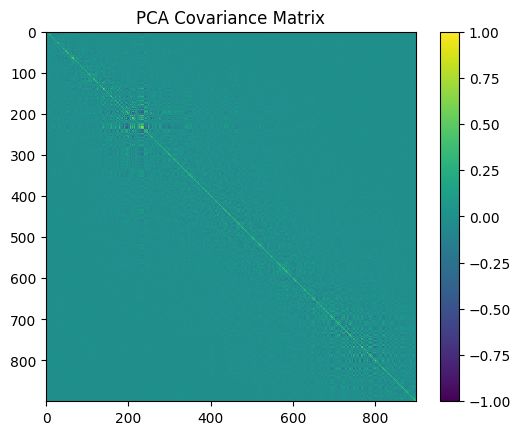

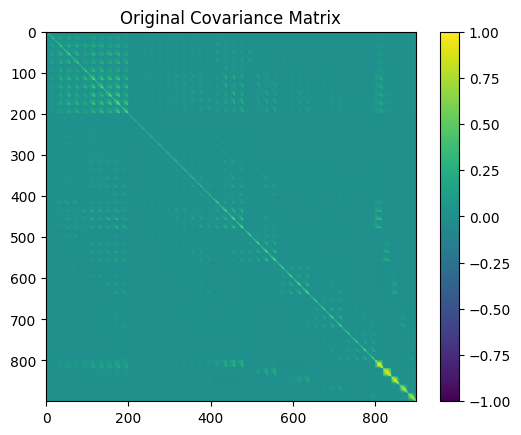

In [7]:
from sklearn.decomposition import PCA

# The number of PCA eigenvalues we want to use
N_pca = 900
models = np.load('data_4_assignment2/models.npy')
# Subtract the mean off each element for numerical stability
mean = np.mean(models, axis=0)
pca = PCA(n_components=N_pca, svd_solver='full')
# Performs the PCA fitting so we can use for transformation
models_pca = pca.fit_transform(models-mean)

# Rotates the covariance matrix into the new basis selected by PCA
rotation_matrix = pca.components_.T
cov_pca = np.matmul(np.matmul(rotation_matrix.T, cov), rotation_matrix)

plt.imshow(cov_pca/np.outer(np.sqrt(np.diag(cov_pca)),np.sqrt(np.diag(cov_pca))),vmin=-1)
plt.title('PCA Covariance Matrix')
plt.colorbar()
plt.show()
plt.imshow(cov/np.outer(np.sqrt(np.diag(cov)), np.sqrt(np.diag(cov))), vmin=-1)
plt.title('Original Covariance Matrix')
plt.colorbar()
plt.show()

#### Increase successively the number of PCA elements from which you compute the Fisher matrix. Convince yourself that if you take all possible PCA elements you converge to same constraining power as for original Fisher analysis. Plot the constraints depending on the number of PCA that you have used. How many PCA elements do you need to have 10% and 1% of the constraining power as the original Fisher analysis?

<ipython-input-8-3b982a124c03>:27: RuntimeWarning: invalid value encountered in sqrt
  parameter_constraints.append(np.sqrt(np.diag(Cov_parameter_pca)))


(0.95, 1.2)

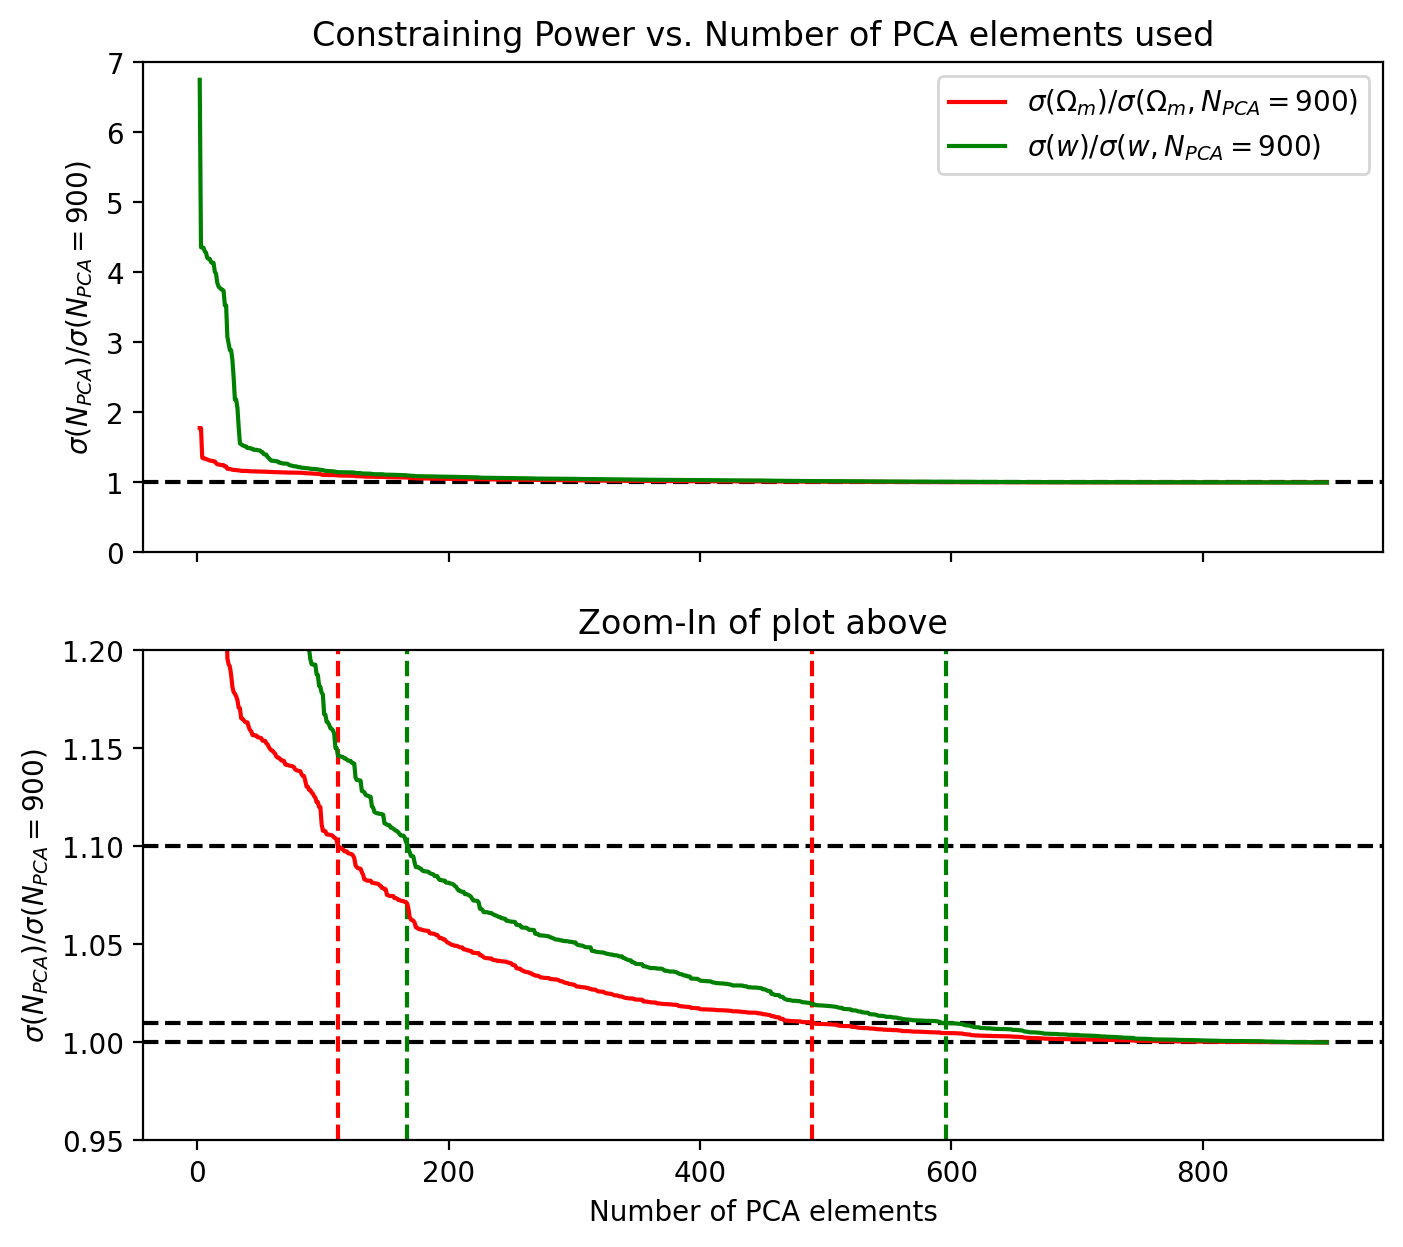

In [8]:
parameter_constraints = []
for N_pca in np.arange(1, 900):

    # Selects the first N_pca elements
    inv_cov_pca = np.linalg.inv(cov_pca[:N_pca, :N_pca])
    # Transforms the derivative and selects the first N_pca elements
    features_om_pca = pca.transform(features_om-mean)[:, :N_pca]
    features_w_pca = pca.transform(features_w-mean)[:, :N_pca]

    # Computes the derivatives based on these variations
    derivative_Om_pca = np.array([(-features_om_pca[3] + 8*features_om_pca[2] -
                                  8*features_om_pca[1] +
                                  features_om_pca[0])/(12*om_shift)]).T
    derivative_w_pca = np.array([(-features_w_pca[3] + 8*features_w_pca[2] -
                                 8*features_w_pca[1] +
                                 features_w_pca[0])/(12*w_shift)]).T

    # Computes the Fisher elements and thus the parameter covariance matrix
    FoM_11 = np.matmul(np.matmul(derivative_Om_pca.T, inv_cov_pca),
                       derivative_Om_pca)[0][0]
    FoM_22 = np.matmul(np.matmul(derivative_w_pca.T, inv_cov_pca),
                       derivative_w_pca)[0][0]
    FoM_12 = np.matmul(np.matmul(derivative_Om_pca.T, inv_cov_pca),
                       derivative_w_pca)[0][0]
    FoM_best_pca = np.array([[FoM_11,FoM_12],[FoM_12,FoM_22]])
    Cov_parameter_pca = inv(FoM_best_pca)
    parameter_constraints.append(np.sqrt(np.diag(Cov_parameter_pca)))

parameter_constraints = np.array(parameter_constraints)

# Makes a plot of the resulting constraints on omega_m and w as a function of
# the different number of PCA elements (relative to their maximal constraining
# power when the number of PCA elements is 900)
fig,ax=plt.subplots(2, 1, sharex=True, sharey=False, dpi=200,
                    figsize=(8,7))
ax[0].axhline(y=1, linestyle='--', color='black')
ax[1].axhline(y=1, linestyle='--', color='black')
ax[1].axhline(y=1.01, linestyle='--', color='black')
ax[1].axhline(y=1.1, linestyle='--', color='black')
ax[1].axvline(x=112, linestyle='--', color='red')
ax[1].axvline(x=489, linestyle='--', color='red')
ax[1].axvline(x=167, linestyle='--', color='green')
ax[1].axvline(x=596, linestyle='--', color='green')
ax[0].plot(np.arange(1, 900),
        parameter_constraints[:, 0]/np.sqrt(np.diag(Cov_parameter))[0], 'r-',
        label=r'$\sigma(\Omega_m)/\sigma(\Omega_m, N_{PCA}=900)$')
ax[0].plot(np.arange(1, 900),
        parameter_constraints[:, 1]/np.sqrt(np.diag(Cov_parameter))[1], 'g-',
        label=r'$\sigma(w)/\sigma(w, N_{PCA}=900)$')
ax[0].set_title('Constraining Power vs. Number of PCA elements used')
ax[1].set_title('Zoom-In of plot above')
ax[1].set_xlabel(r'Number of PCA elements')
ax[0].set_ylabel(r'$\sigma(N_{PCA})/\sigma(N_{PCA}=900)$')
ax[1].set_ylabel(r'$\sigma(N_{PCA})/\sigma(N_{PCA}=900)$')
ax[0].legend()
ax[1].plot(np.arange(1, 900),
        parameter_constraints[:, 0]/np.sqrt(np.diag(Cov_parameter))[0], 'r-',
        label=r'$\sigma(\Omega_m)/\sigma(\Omega_m, N_{PCA}=900)$')
ax[1].plot(np.arange(1, 900),
        parameter_constraints[:, 1]/np.sqrt(np.diag(Cov_parameter))[1], 'g-',
        label=r'$\sigma(w)/\sigma(w, N_{PCA}=900)$')
ax[0].set_ylim(0, 7)
ax[1].set_ylim(0.95, 1.2)

# We note that the constraints for both omega_m and w asymptotically approach
# their minimum constraints as the number of PCA elements goes to 900 (which
# fulfills one of the requirements we must meet), as seen visually with the
# solid line representing relative error approaching y=1 asymptotically

# We also zoom in closer to find how many PCA elements are required for the
# constraints on omega_m and w to be within 10% and 1% of their maximum
# constraining power; to do this we use y=1.1 and y=1.01 for the ratio plot
# and use trial by error to plot the x value associated with these points
# (there is probably a more rigorous way to do this, but I'm forgetting some
# of my computational skills haha)

# For omega_m we get within 10% and 1% of minimal constraints at 112 and 489
# PCA elements, while for w we get within 10% and 1% of minimal constraints for
# 167 and 596 PCA elements; we take away from this analysis that PCA expresses
# our dataset in a more optimal basis that allows us to neglect a large number
# of elements and still obtain strong constraining power anyway